In [ ]:
%%bash
# Do not change or modify this cell
# Need to install pyspark
# if pyspark is already installed, will print a message indicating requirement already satisfied
pip install pyspark
pip install pyspark_dist_explore

  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=0dd0a8580eef485389a20d07864bc26cc84f10262a7d697aed98e25faf5fd8bb
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
!git clone https://github.com/warrenfds/IST-718.git

Cloning into 'IST-718'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 0), reused 9 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.


## Libraries

In [ ]:
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml import feature
from pyspark.ml import classification
from pyspark.ml.classification import GBTClassifier
from pyspark_dist_explore import hist
from pyspark.sql.functions import *
import io
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

spark = SparkSession.builder.getOrCreate()
spark_context = spark.sparkContext
sqlContext = SQLContext(spark_context)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


# **Exploratory Data Analysis**


## Preprocessing

In [ ]:
df = spark.read.option("inferSchema", True).option("header", True).csv("IST-718/data_files/")
df.show(5)
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()
df.dtypes
df.groupby("target").count().show()

+--------------------+----------------+--------------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+----------+--------+------+
|               track|          artist|                 uri|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|time_signature|chorus_hit|sections|target|
+--------------------+----------------+--------------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+----------+--------+------+
|Jealous Kind Of F...|   Garland Green|spotify:track:1dt...|       0.417|  0.62|  3|  -7.727| 1.0|     0.0403|        0.49|             0.0|  0.0779|  0.845|185.655|   173533.0|           3.0|  32.94975|     9.0|   1.0|
|       Initials B.B.|Serge Gainsbourg|spotify:track:5hj...|       0.498| 0.505|  3| -12.475| 1.0|     0.0337|       0.0

In [ ]:
df = df.withColumn("target", when(df.target != 0, 1).otherwise(df.target))

In [ ]:
df.groupby("target").count().show()

+------+-----+
|target|count|
+------+-----+
|   0.0|20506|
|   1.0|20600|
+------+-----+



Except the track, artist, uri. every other feature in this dataset is continuous<br>
We need to change the structure of danceability, energy, key, and loudness.<br>
Also, there is not a single NA/ Null value in the entire dataset but there are null values after the columns are typecasted.


In [ ]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----+------+---+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----------+--------+------+
|track|artist|uri|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|duration_ms|time_signature|chorus_hit|sections|target|
+-----+------+---+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----------+--------+------+
|    0|     0|  0|           0|     0|  0|       0|   0|          0|           0|               0|       0|      0|    0|          0|             0|         0|       0|     0|
+-----+------+---+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----------+--------+------+



Casting some fields from string type to nemerical types

In [ ]:
from pyspark.sql.types import DoubleType
df = df.withColumn('loudness', df['loudness'].cast(DoubleType())) \
.withColumn('key', df['key'].cast(DoubleType())) \
.withColumn('energy', df['energy'].cast(DoubleType())) \
.withColumn('danceability', df['danceability'].cast(DoubleType()))
df.summary().show()
df.dtypes

+-------+--------------------+------------------+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|summary|               track|            artist|                 uri|      danceability|            energy|               key|           loudness|              mode|        speechiness|       acousticness|   instrumentalness|           liveness|           valence|             tempo|       duration_ms|    time_signature|       chorus_hit|          sections|            target|
+-------+--------------------+------------------+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+----------------

[('track', 'string'),
 ('artist', 'string'),
 ('uri', 'string'),
 ('danceability', 'double'),
 ('energy', 'double'),
 ('key', 'double'),
 ('loudness', 'double'),
 ('mode', 'double'),
 ('speechiness', 'double'),
 ('acousticness', 'double'),
 ('instrumentalness', 'double'),
 ('liveness', 'double'),
 ('valence', 'double'),
 ('tempo', 'double'),
 ('duration_ms', 'double'),
 ('time_signature', 'double'),
 ('chorus_hit', 'double'),
 ('sections', 'double'),
 ('target', 'double')]

In [ ]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----+------+---+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----------+--------+------+
|track|artist|uri|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|duration_ms|time_signature|chorus_hit|sections|target|
+-----+------+---+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----------+--------+------+
|    0|     0|  0|          47|    18|  4|       2|   0|          0|           0|               0|       0|      0|    0|          0|             0|         0|       0|     0|
+-----+------+---+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----------+--------+------+



In [ ]:
df = df.drop('artist',
 'track',
 'uri',
 'time_signature',
 'duration_ms')

In [ ]:
df = df.dropna()
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+----------+--------+------+
|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|chorus_hit|sections|target|
+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+----------+--------+------+
|           0|     0|  0|       0|   0|          0|           0|               0|       0|      0|    0|         0|       0|     0|
+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+----------+--------+------+



In total there are 17,790 rows
The max no. of na values are in danceability<br>
Then energy has 5 na values,and key and loudness has 2 na values each. <br>
If we take a closer look we can see that all of these NA values we are getting is after the conversion of data structure from string to double.<br>
Hence we can conclude that the rows with na values are string type with text in it and it won't affect the analysis even if we keep it the way it is now.

## Data Visualization

*   Converting datasets into pd and grouping by categorical variables of the datasets
*   The above steps is to avoid the binning for visualization of histograms.
*   There is usage of pandas in this section for visualization and matplot library
*   For entire pre-processing spark's rdd is performed






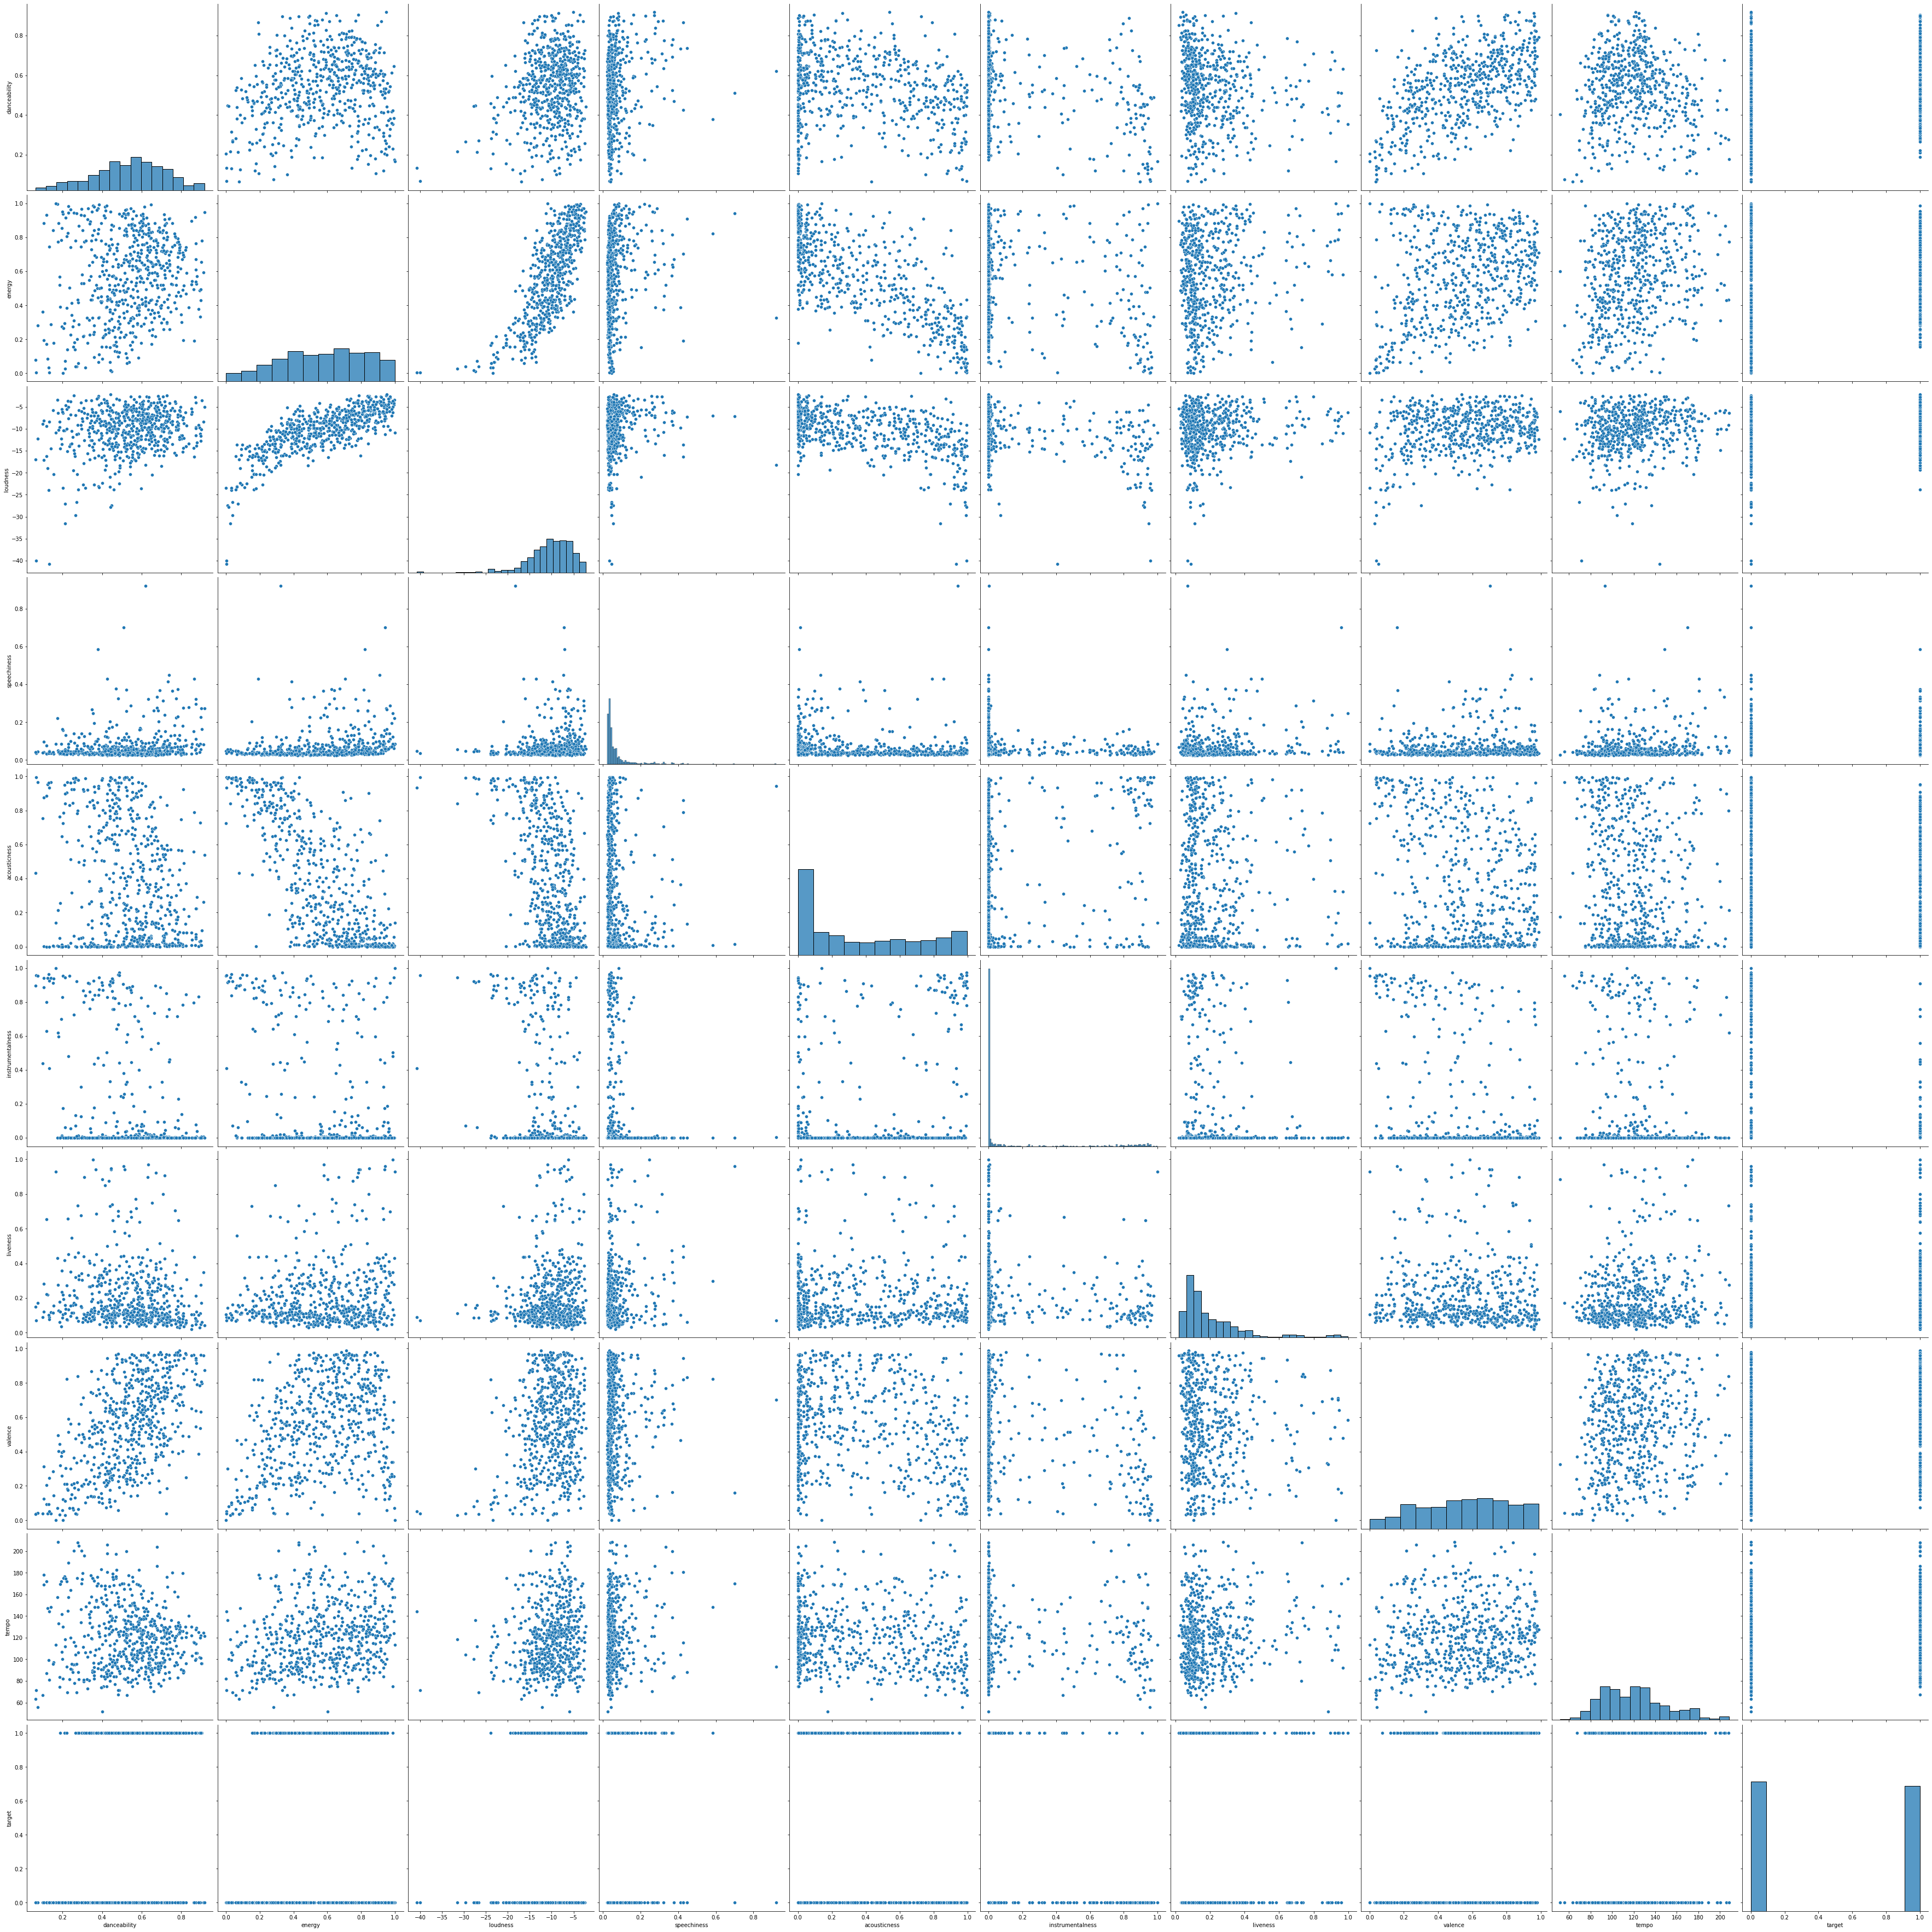

In [ ]:
# large file, sample 1% - 2% before plotting pairplot
# 0.015% of (53,000 rows) is sufficient to just get a general peek at the data
df_pp = df.select('danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo','target').sample(fraction=0.015, seed=28).toPandas() 
sns.pairplot(df_pp, height=5)

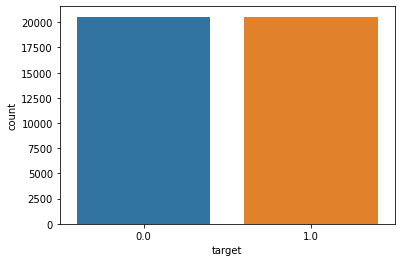

In [ ]:
sns.countplot(x='target',data=df.toPandas())

In [ ]:
target = "target"
num_var = list(set(df.columns)- set([target]))

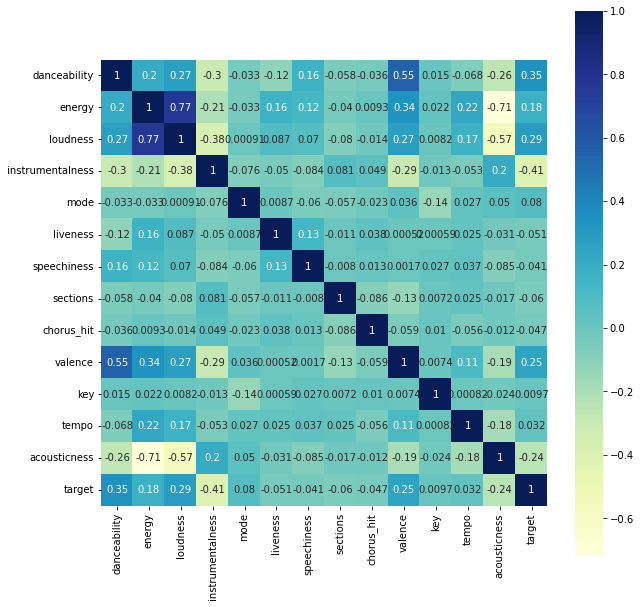

In [ ]:
#Check correlations
plt.figure(figsize=(10, 10))
numeric_var = num_var+[target]
correlation = df[numeric_var].toPandas().iloc[:, 0:].corr()
sns.heatmap(correlation, vmax=1, annot=True,square=True, cmap="YlGnBu")

In [ ]:
all_songs = df.toPandas()
all_songs.head(3)
#spfeatures_var_list = ['danceability', 'energy', 'key', 'loudness','mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness','valence']
spfeatures_var_list = ['danceability','energy','key','loudness','speechiness','acousticness','instrumentalness', 'liveness','valence','tempo','chorus_hit','sections'] 
all_songs_hits = all_songs[spfeatures_var_list].loc[all_songs['target'] == 1]
all_songs_flops = all_songs[spfeatures_var_list].loc[all_songs['target'] == 0] 

In [ ]:
all_songs_flops.head()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,chorus_hit,sections
1,0.498,0.505,3.0,-12.475,0.0337,0.018,0.107000,0.176,0.797,101.801,48.82510,10.0
2,0.657,0.649,5.0,-13.392,0.0380,0.846,0.000004,0.119,0.908,115.940,37.22663,12.0
3,0.590,0.545,7.0,-12.058,0.1040,0.706,0.024600,0.061,0.967,105.592,24.75484,8.0
4,0.515,0.765,11.0,-3.515,0.1240,0.857,0.000872,0.213,0.906,114.617,21.79874,14.0
5,0.697,0.673,0.0,-10.573,0.0266,0.714,0.919000,0.122,0.778,112.117,65.48604,7.0


In [ ]:
hits_means = pd.DataFrame(all_songs_hits.describe().loc['mean'])
flops_means = pd.DataFrame(all_songs_flops.describe().loc['mean'])
means_joined = pd.concat([hits_means,flops_means], axis = 1)
means_joined.columns = ['hit_mean', 'flop_mean']
means_joined


,hit_mean,flop_mean
danceability,0.601237,0.478463
energy,0.624296,0.535468
key,5.248528,5.180191
loudness,-8.702237,-11.723479
speechiness,0.069444,0.076427
acousticness,0.280814,0.446639
instrumentalness,0.030687,0.278086
liveness,0.192637,0.210349
valence,0.609578,0.475872
tempo,120.288280,118.423187


In [ ]:
df.dtypes

[('danceability', 'double'),
 ('energy', 'double'),
 ('key', 'double'),
 ('loudness', 'double'),
 ('mode', 'double'),
 ('speechiness', 'double'),
 ('acousticness', 'double'),
 ('instrumentalness', 'double'),
 ('liveness', 'double'),
 ('valence', 'double'),
 ('tempo', 'double'),
 ('chorus_hit', 'double'),
 ('sections', 'double'),
 ('target', 'double')]

In [ ]:
#hits_means

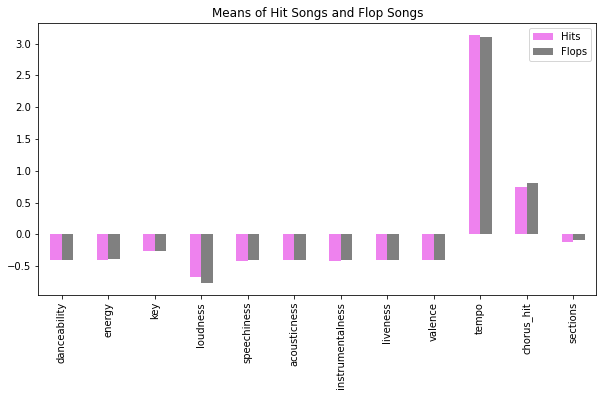

In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
means_joined_scaled = pd.DataFrame(ss.fit_transform(means_joined),index= means_joined.index, columns = means_joined.columns)
means_joined_scaled
means_joined_scaled.plot(kind = 'bar', figsize=(10, 5), color = ('violet', 'grey'), title = 'Means of Hit Songs and Flop Songs')
plt.legend(labels=['Hits', 'Flops'], loc='upper right')
plt.show()

*   If we take a close look between hit and flop songs you wont be able to tell much of a difference, the reason is that if you see duration_ms, time signature ,etc those no.s are quite high in comparision with the other factors affecting the dataset
*   Bifurcationg the datset for visualization and proper 



In [ ]:
all_songs = df.toPandas()
all_songs.head(3)
#spfeatures_var_list = ['danceability', 'energy', 'key', 'loudness','mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness','valence']
spfeatures_var_list = ['danceability', 'energy', 'key', 'loudness','mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness','valence'] 
all_songs_hits = all_songs[spfeatures_var_list].loc[all_songs['target'] == 1]
all_songs_flops = all_songs[spfeatures_var_list].loc[all_songs['target'] == 0]

In [ ]:
hits_means = pd.DataFrame(all_songs_hits.describe().loc['mean'])
flops_means = pd.DataFrame(all_songs_flops.describe().loc['mean'])
means_joined = pd.concat([hits_means,flops_means], axis = 1)
means_joined.columns = ['hit_mean', 'flop_mean']
means_joined

,hit_mean,flop_mean
danceability,0.601237,0.478463
energy,0.624296,0.535468
key,5.248528,5.180191
loudness,-8.702237,-11.723479
mode,0.730064,0.656344
speechiness,0.069444,0.076427
acousticness,0.280814,0.446639
instrumentalness,0.030687,0.278086
liveness,0.192637,0.210349
valence,0.609578,0.475872


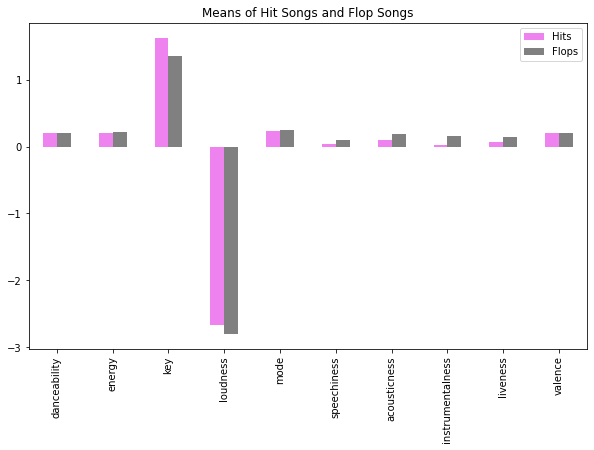

In [ ]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
means_joined_scaled = pd.DataFrame(ss.fit_transform(means_joined),index= means_joined.index, columns = means_joined.columns)
means_joined_scaled
means_joined_scaled.plot(kind = 'bar', figsize=(10, 6), color = ('violet', 'grey'), title = 'Means of Hit Songs and Flop Songs')
plt.legend(labels=['Hits', 'Flops'], loc='upper right')
plt.show()

In [ ]:
from matplotlib.pyplot import suptitle
#ax = sns.pairplot(all_songs[['danceability', 'energy', 'key',	'loudness',	'mode',	'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence',	'tempo', 'duration_ms',	'time_signature', 'chorus_hit',	'sections']])
#ax.fig.suptitle("Song features pairplot")

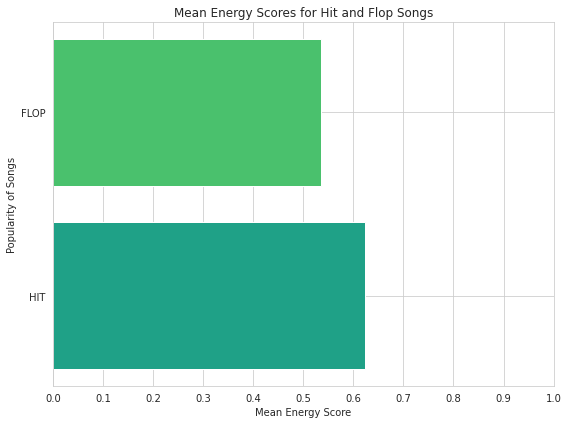

In [ ]:
mean_energy = {'HIT': all_songs_hits['energy'].mean(), 
                     'FLOP': all_songs_flops['energy'].mean()}
#visualizing mean scores
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.barh(y=list(mean_energy.keys()), 
            width=list(mean_energy.values()), 
            color=[sns.color_palette('viridis')[3],sns.color_palette('viridis')[4]]) 
    ax.set_xlim(0, 1)
    ax.set_xticks(np.arange(0,1.1,0.1))
    ax.set_ylabel('Popularity of Songs')
    ax.set_xlabel('Mean Energy Score')
    ax.set_title('Mean Energy Scores for Hit and Flop Songs')
    plt.tight_layout()

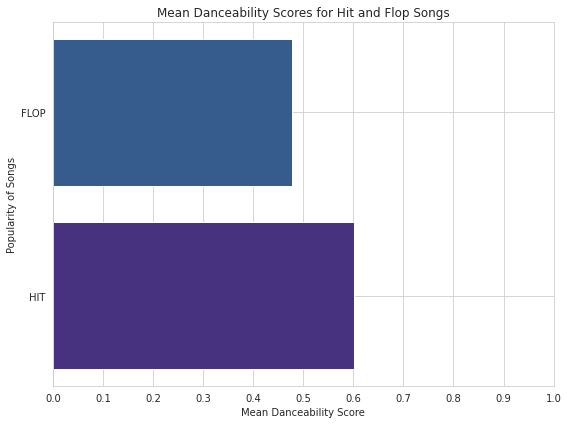

In [ ]:
mean_danceability = {'HIT': all_songs_hits['danceability'].mean(), 
                     'FLOP': all_songs_flops['danceability'].mean()}

#visualizing mean scores
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.barh(y=list(mean_danceability.keys()), 
            width=list(mean_danceability.values()), 
            color=[sns.color_palette('viridis')[0],sns.color_palette('viridis')[1]]) 
    ax.set_xlim(0, 1)
    ax.set_xticks(np.arange(0,1.1,0.1))
    ax.set_ylabel('Popularity of Songs')
    ax.set_xlabel('Mean Danceability Score')
    ax.set_title('Mean Danceability Scores for Hit and Flop Songs')
    plt.tight_layout()

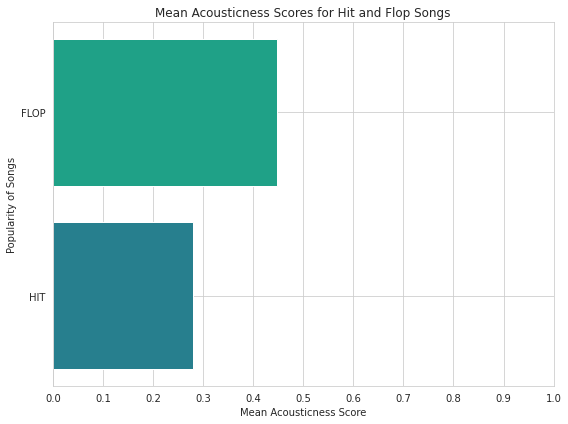

In [ ]:
mean_acousticness = {'HIT': all_songs_hits['acousticness'].mean(), 
                     'FLOP': all_songs_flops['acousticness'].mean()}

#visualizing mean scores
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.barh(y=list(mean_acousticness.keys()), 
            width=list(mean_acousticness.values()), 
            color=[sns.color_palette('viridis')[2],sns.color_palette('viridis')[3]]) 
    ax.set_xlim(0, 1)
    ax.set_xticks(np.arange(0,1.1,0.1))
    ax.set_ylabel('Popularity of Songs')
    ax.set_xlabel('Mean Acousticness Score')
    ax.set_title('Mean Acousticness Scores for Hit and Flop Songs')
    plt.tight_layout()

##Model Implementation
* Trained and tested three different models - Logistic Regression, Random Forest classifier and Gradient Boosting classifier. 
* We used a 70/30 split for training/testing dataset. A validation set did not have to be made because cross validation was used to pick the best model. 

In [ ]:
training_df, testing_df = df.randomSplit([0.7, 0.3])

In [ ]:
training_df.show()

+------------+-------+----+--------+----+-----------+------------+----------------+--------+-------+-------+----------+--------+------+
|danceability| energy| key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|chorus_hit|sections|target|
+------------+-------+----+--------+----+-----------+------------+----------------+--------+-------+-------+----------+--------+------+
|         0.0|  0.377|10.0|  -6.777| 0.0|        0.0|       0.776|             0.0|    0.39|    0.0|    0.0|  26.02934|     7.0|   1.0|
|      0.0593| 0.0431| 0.0| -23.958| 1.0|     0.0467|       0.993|           0.935|   0.237| 0.0203| 54.756|  52.97325|    17.0|   0.0|
|      0.0623|0.00246| 0.0| -39.609| 1.0|     0.0457|       0.972|           0.853|  0.0771| 0.0428|   70.2|  76.32757|     9.0|   0.0|
|       0.063| 0.0295| 2.0| -25.697| 0.0|     0.0361|       0.976|           0.947|   0.108| 0.0572| 67.369|  23.08325|    27.0|   0.0|
|      0.0633|  0.241| 5.0| -11.205| 1.0|     0.

In [ ]:
training_df.columns[:-1]

['danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'chorus_hit',
 'sections']

In [ ]:
training_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in training_df.columns]).show()

+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+----------+--------+------+
|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|chorus_hit|sections|target|
+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+----------+--------+------+
|           0|     0|  0|       0|   0|          0|           0|               0|       0|      0|    0|         0|       0|     0|
+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+----------+--------+------+



In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

va = VectorAssembler().setInputCols(training_df.columns[:-1]).setOutputCol('features')
bce = BinaryClassificationEvaluator(labelCol="target")

# Training and testing base models with no hyperparameters tuned

lr = LogisticRegression().\
    setLabelCol('target').\
    setFeaturesCol('features').\
    setRegParam(0.0).\
    setMaxIter(100).\
    setElasticNetParam(0.)
lr_pipe = Pipeline(stages=[va, lr])
model1 = lr_pipe.fit(training_df)

rf = RandomForestClassifier(labelCol="target")
rf_pipeline = Pipeline(stages=[va, rf])
rf_model1 = rf_pipeline.fit(training_df)



In [ ]:
bce.evaluate(model1.transform(testing_df))

0.8017337599187299

In [ ]:
bce.evaluate(rf_model1.transform(testing_df))

0.8204896220233572

In [ ]:
# Tuning hyperparameters using a ParamGrid and running 3-fold cross validation
# to pick the best model

lr_grid = ParamGridBuilder().\
    addGrid(lr.regParam, [0., 0.02, 0.04]).\
    addGrid(lr.elasticNetParam, [0., 0.5, 1]).\
    build()

lrcv = CrossValidator(estimator = lr_pipe,
                      estimatorParamMaps = lr_grid,
                      evaluator = bce,
                      numFolds = 3)
lrcvModel = lrcv.fit(training_df)
lrpredictions = lrcvModel.transform(testing_df)

rfparamGrid = (ParamGridBuilder()\
             .addGrid(rf.maxDepth, [10, 15])\
             .addGrid(rf.numTrees, [25, 50])\
             .build())

rfcv = CrossValidator(estimator = rf_pipeline,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = bce,
                      numFolds = 3)

rfcvModel = rfcv.fit(training_df)
rfpredictions = rfcvModel.transform(testing_df)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print('LR-AUC:', bce.evaluate(lrpredictions))
print('RF-AUC:', bce.evaluate(rfpredictions))

LR-AUC: 0.8017357016515311
RF-AUC: 0.851614747657459


In [ ]:
bcevaluator = BinaryClassificationEvaluator(labelCol="target", metricName="areaUnderPR")

In [ ]:
print('LR-AUCPR:', bcevaluator.evaluate(lrpredictions))
print('RF-AUCPR:', bcevaluator.evaluate(rfpredictions))

LR-AUCPR: 0.7598635553580294
RF-AUCPR: 0.8232056511136383


In [ ]:
bestPipelineLR = lrcvModel.bestModel
bestModelLR = bestPipelineLR.stages[1]
print('regParam - ', bestModelLR._java_obj.getRegParam())
print('ElasticNetParam - ', bestModelLR._java_obj.getElasticNetParam())

regParam -  0.0
ElasticNetParam -  0.5


In [ ]:
# Your code here
bestPipeline = rfcvModel.bestModel
bestModel = bestPipeline.stages[1]
print('numTrees - ', bestModel.getNumTrees)
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))

numTrees -  50
maxDepth -  15


In [ ]:
## LR feature importance

coeff_list = bestPipelineLR.stages[-1].coefficients

coeff_value = {'coefficient': training_df.columns[:-1], 'value': np.abs(coeff_list)}
coefficients_df = pd.DataFrame(data= coeff_value).sort_values('value', ascending=False)
display(coefficients_df)

,coefficient,value
7,instrumentalness,3.397320
0,danceability,3.381896
5,speechiness,3.366506
1,energy,1.837478
6,acousticness,1.357218
4,mode,0.375989
9,valence,0.343575
8,liveness,0.167352
3,loudness,0.109660
12,sections,0.017956


Text(0.5, 1.0, 'Feature Importances')

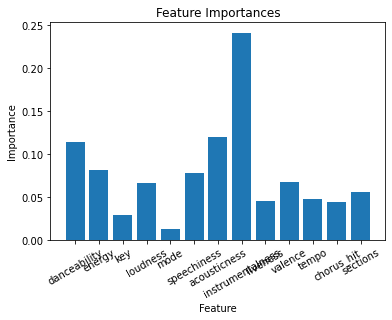

In [ ]:
## RF feature importance
rf_importances = bestModel.featureImportances
x_values = list(range(len(rf_importances)))

rf_feature_importance = pd.DataFrame(list(zip(training_df.columns[:-1], rf_importances.toArray())), columns =['feature', 'importance']).sort_values('importance', ascending = False)

plt.bar(x_values, rf_importances, orientation = 'vertical')
plt.xticks(x_values, training_df.columns[:-1], rotation=30)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [ ]:
display(rf_feature_importance)

,feature,importance
7,instrumentalness,0.240993
6,acousticness,0.119559
0,danceability,0.113410
1,energy,0.080884
5,speechiness,0.077968
9,valence,0.066869
3,loudness,0.066322
12,sections,0.055835
10,tempo,0.047848
8,liveness,0.045551


In [ ]:
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'target')

pipeline_gbt = Pipeline(stages= [va, gbt])
gbt_model = pipeline_gbt.fit(training_df)
gbt_predictions_test= gbt_model.transform(testing_df)

#bce.evaluate(gbt_predictions_test)

In [ ]:
gbtparamGrid = (ParamGridBuilder()\
             .addGrid(gbt.maxDepth, [5, 10])\
             .addGrid(gbt.maxIter, [6, 10, 12])\
             .build())

gbtcv = CrossValidator(estimator = pipeline_gbt,
                      estimatorParamMaps = gbtparamGrid,
                      evaluator = bce,
                      numFolds = 3)

gbtcvModel = gbtcv.fit(training_df)
gbtpredictions = gbtcvModel.transform(testing_df)

bestPipeGBT = gbtcvModel.bestModel
bestModelGBT = bestPipeGBT.stages[1]
print('maxIter - ', bestModelGBT.getOrDefault('maxIter'))
print('maxDepth - ', bestModelGBT.getOrDefault('maxDepth'))

maxIter -  12
maxDepth -  5


In [ ]:
print('GBT-AUC:', bce.evaluate(gbtpredictions))

GBT-AUC: 0.8340068885232049


Text(0.5, 1.0, 'Feature Importances')

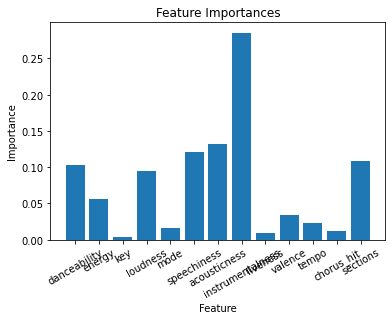

In [ ]:
## GBT feature importance
gbt_importances = bestModelGBT.featureImportances
#print(importances.toArray())
x_values = list(range(len(gbt_importances)))

gbt_feature_importance = pd.DataFrame(list(zip(training_df.columns[:-1], rf_importances.toArray())), columns =['feature', 'importance']).sort_values('importance', ascending = False)

plt.bar(x_values, gbt_importances, orientation = 'vertical')
plt.xticks(x_values, training_df.columns[:-1], rotation=30)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [ ]:
display(gbt_feature_importance)

,feature,importance
7,instrumentalness,0.240993
6,acousticness,0.119559
0,danceability,0.113410
1,energy,0.080884
5,speechiness,0.077968
9,valence,0.066869
3,loudness,0.066322
12,sections,0.055835
10,tempo,0.047848
8,liveness,0.045551


## Model Comparison

In [ ]:
compare_1_df = pd.DataFrame({'Model': ["LR", "RF", "GBT"], 'AUROC': [bce.evaluate(lrpredictions), bce.evaluate(rfpredictions), bce.evaluate(gbtpredictions)]})
display(compare_1_df)

,Model,AUROC
0,LR,0.801732
1,RF,0.851616
2,GBT,0.834007


In [ ]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


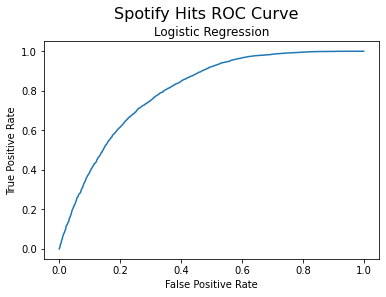

In [ ]:
preds = lrpredictions.select('target','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['target'])))
points = CurveMetrics(preds).get_curve('roc')
#print(points)

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('Logistic Regression',fontsize=12)
plt.suptitle('Spotify Hits ROC Curve',fontsize=16, y=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


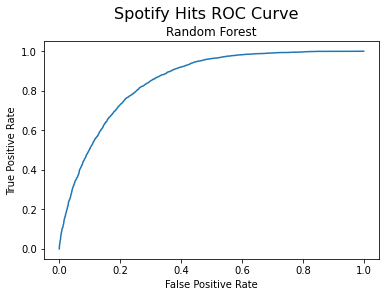

In [ ]:
preds = rfpredictions.select('target','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['target'])))
points = CurveMetrics(preds).get_curve('roc')
#print(points)

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('Random Forest',fontsize=12)
plt.suptitle('Spotify Hits ROC Curve',fontsize=16, y=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


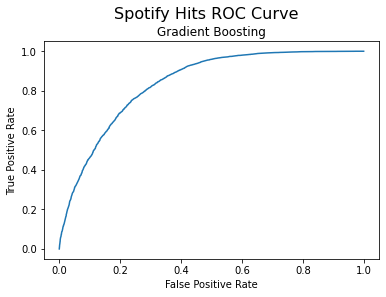

In [ ]:
preds1 = gbt_predictions_test.select('target','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['target'])))
points1 = CurveMetrics(preds1).get_curve('roc')
#print(points)

plt.figure()
x_val = [x[0] for x in points1]
y_val = [x[1] for x in points1]
plt.title('Gradient Boosting',fontsize=12)
plt.suptitle('Spotify Hits ROC Curve',fontsize=16, y=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


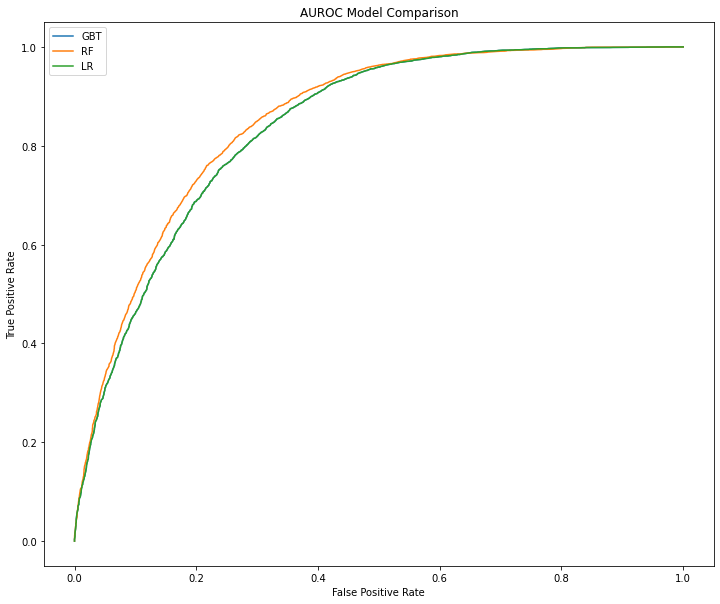

In [ ]:
preds_gbt = gbt_predictions_test.select('target','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['target'])))
points_gbt = CurveMetrics(preds_gbt).get_curve('roc')

preds_rf = rfpredictions.select('target','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['target'])))
points_rf = CurveMetrics(preds_rf).get_curve('roc')

preds_lr = gbt_predictions_test.select('target','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['target'])))
points_lr = CurveMetrics(preds_lr).get_curve('roc')

plt.figure(figsize=(12,10))
x_val_gbt = [x[0] for x in points_gbt]
y_val_gbt = [x[1] for x in points_gbt]
x_val_rf = [x[0] for x in points_rf]
y_val_rf = [x[1] for x in points_rf]

x_val_lr = [x[0] for x in points_lr]
y_val_lr = [x[1] for x in points_lr]

plt.plot(x_val_gbt, y_val_gbt, label = 'GBT')
plt.plot(x_val_rf, y_val_rf, label = 'RF')
plt.plot(x_val_lr, y_val_lr, label = 'LR')
plt.title('AUROC Model Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()